In [332]:
from pathlib import Path

data_dir = Path("data")

def filter_path(path):
    return (path.parent.stem != ".ipynb_checkpoints"
        and "week7" not in str(path)
        and "week8" not in str(path))

data_paths = sorted(filter(filter_path, data_dir.glob("**/*.csv")))
data_paths

[PosixPath('data/week6/40secondblinkwithlaps.csv'),
 PosixPath('data/week6/40seconddoubleblink.csv'),
 PosixPath('data/week6/40seconddoublelookleft.csv'),
 PosixPath('data/week6/40seconddoublelookright.csv'),
 PosixPath('data/week6/40secondlookleftlaps.csv'),
 PosixPath('data/week6/40secondlookrightlaps.csv'),
 PosixPath('data/week9/2204blinks.csv'),
 PosixPath('data/week9/2204looklefts.csv'),
 PosixPath('data/week9/2204looklefts1.csv'),
 PosixPath('data/week9/2204lookrights.csv'),
 PosixPath('data/week9/2204lookrights1.csv'),
 PosixPath('data/week9/double/blinks/2204doubleblinks.csv'),
 PosixPath('data/week9/double/blinks/2204doubleblinks1.csv'),
 PosixPath('data/week9/double/left/2204doubleleft.csv'),
 PosixPath('data/week9/double/left/2204doubleleft1.csv'),
 PosixPath('data/week9/double/right/2204doubleright.csv'),
 PosixPath('data/week9/double/right/2204doubleright1.csv'),
 PosixPath('data/week9/non_event/noneventdata2204.csv'),
 PosixPath('data/week9/non_event/noneventdata22204.cs

In [160]:
import numpy as np

def load_data(path, with_laps="laps.txt", reverse=True):
    laps = []
    if with_laps:
        name = path.stem
        found = False
        laps_txt = path.parent / with_laps
        if laps_txt.exists():
            with open(laps_txt) as f:
                for line in f.readlines():
                    line = line.strip()
                    if not line:
                        pass
                    elif not line.replace(".", "").isnumeric():
                        if found:
                            break
                        if name == line:
                            found = True
                    elif found:
                        laps.append(float(line))
                laps = np.cumsum(np.array(laps))
    arr = np.genfromtxt(path, delimiter=",")
    time, amp = arr.T
    if time[-1] < time[0]:
        time = np.max(time) - time
        amp = amp[::-1]

    return time, amp, laps if len(laps) else None

In [3]:
import matplotlib.pyplot as plt

def plot_data(time, amp, laps=None, /, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(time, amp)
    if laps is not None:
        ax.vlines(laps, np.min(amp), np.max(amp),
                  color="red")

In [4]:
figure_dir = Path("figure")

for path in data_paths:
    fig, ax = plt.subplots(figsize=(12, 4))
    time, amp, laps = load_data(path)
    plot_data(time, amp, laps)
    ax.set_title(path.stem)
    where = figure_dir / path.relative_to(data_dir).with_suffix(".png")
    where.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(where)
    plt.close()

## Event Detection

### Moving Average of Absolute Difference

In [350]:
from scipy.signal import find_peaks

figure_dir = Path("figure/abs_diff_020/")

for path in tqdm(data_paths):
    window_sec = 1.0
    window_n = int(10_000 * window_sec)
    
    time, amp, laps = load_data(path)
    
    amp_mean = np.mean(amp)
    abs_diff = np.r_[0, np.abs(np.diff(amp))]
    moving_avg = np.convolve(abs_diff, np.ones(window_n), "full")[:-(window_n - 1)] / window_n
    high_peaks, _ = find_peaks(amp - amp_mean, prominence=100)
    low_peaks, _ = find_peaks(amp_mean - amp, prominence=100)
    
    fig = plt.figure(figsize=(12, 4))
    plot_data(time, amp)
    plot_data(time, np.where(moving_avg > 0.02, max(amp), min(amp)))
    plt.scatter(time[high_peaks], amp[high_peaks], c="green", marker="x")
    plt.scatter(time[low_peaks], amp[low_peaks], c="red", marker="x")
    
    where = figure_dir / path.relative_to(data_dir).with_suffix(".png")
    where.parent.mkdir(parents=True, exist_ok=True)    
    fig.savefig(where)
    plt.close()

  0%|          | 0/25 [00:00<?, ?it/s]

### Variance

In [367]:
from scipy.signal import find_peaks

figure_dir = Path("figure/prominence_90/")

for path in tqdm(data_paths):
    window_sec = 1.0
    window_n = int(10_000 * window_sec)
    
    time, amp, laps = load_data(path)
    
    amp_med = np.median(amp)
    error = amp - amp_med
    std = np.convolve(error ** 2, np.ones(window_n), "full")[:-(window_n - 1)] / window_n
    high_peaks, _ = find_peaks(amp - amp_mean, prominence=90)
    low_peaks, _ = find_peaks(amp_mean - amp, prominence=90)
    
    fig = plt.figure(figsize=(12, 4))
    plot_data(time, amp)
    plot_data(time, np.where(std > 150, max(amp), min(amp)))
    plt.scatter(time[high_peaks], amp[high_peaks], c="green", marker="x")
    plt.scatter(time[low_peaks], amp[low_peaks], c="red", marker="x")
    
    where = figure_dir / path.relative_to(data_dir).with_suffix(".png")
    where.parent.mkdir(parents=True, exist_ok=True)    
    fig.savefig(where)
    plt.close()

  0%|          | 0/25 [00:00<?, ?it/s]

### Windowed Visualization

In [48]:
def sliding_window(time,
                   amp,
                   laps=None,
                   window_sec=1.0,
                   window_inc=0.2,
                   show_progress=True):
    n_window = int((max(time) - window_sec) // window_inc)
    iter_window = range(n_window)
    if show_progress:
        from tqdm.auto import tqdm
        iter_window = tqdm(iter_window, leave=False)
    for i in iter_window:
        start_sec = window_inc * i
        end_sec = start_sec + window_sec
        mask = (start_sec <= time) & (time < end_sec)
        if laps is not None:
            laps_masked = laps[(start_sec <= laps) & (laps < end_sec)]
            yield time[mask], amp[mask], laps_masked
        else:
            yield time[mask], amp[mask], None

# windows = sliding_window(time, amp, laps)
# for _ in range(25):
#     next(windows)
# window_time, window_amp, window_laps = next(windows)
# plt.figure(figsize=(12, 4))
# plot_data(window_time, window_amp, window_laps)
# plt.show()

In [18]:
import pandas as pd
from tqdm.auto import tqdm
from tsfeatures import acf_features

df_acf = pd.DataFrame()
for path in filter(lambda path: any(keyword in str(path)
                                    for keyword in ("week6", "week9")),
                   tqdm(data_paths)):
    time, amp, laps = load_data(path)
    feat = [acf_features(amp) for _, amp, _ in sliding_window(time, amp)]
    df_acf = pd.concat([df_acf, pd.DataFrame(feat)], ignore_index=True)

df_acf.to_csv("data/week6_9_acf.csv")

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = df_acf.to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clustering = KMeans(n_clusters=3)
y = clustering.fit_predict(X_scaled)
np.unique(y, return_counts=True)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10
0,0.999924,9.988690,0.072457,0.051893,-0.499958,0.249958
1,0.999920,9.984171,0.137108,0.186062,-0.484861,0.235090
2,0.999934,9.986708,0.139567,0.192562,-0.499928,0.249928
3,0.999369,9.921325,0.726362,5.233059,-0.499345,0.249345
4,0.999733,9.941918,0.252239,0.628460,-0.499860,0.249860
...,...,...,...,...,...,...
2976,0.999345,9.917802,0.033389,0.010879,-0.499980,0.249980
2977,0.999468,9.933783,0.033331,0.010836,-0.499980,0.249980
2978,0.999269,9.909868,0.033217,0.010783,-0.499980,0.249980
2979,0.999377,9.921690,0.390985,1.492148,-0.499697,0.249697


In [73]:
def predict_event(time, amp,
                  event_classifier,
                  window_sec=1.2,
                  window_inc=0.05,
                  event_skip=None):
    if event_skip is None:
        event_skip = int(window_sec // window_inc)
    windows = sliding_window(time, amp)
    while (window := next(windows, None)) is not None:
        window_time, window_amp, _ = window
        has_event = event_classifier(window_amp)
        if has_event:
            yield min(window_time), max(window_time)
            for _ in range(event_skip):
                next(windows, None)

  0%|          | 0/94 [00:00<?, ?it/s]

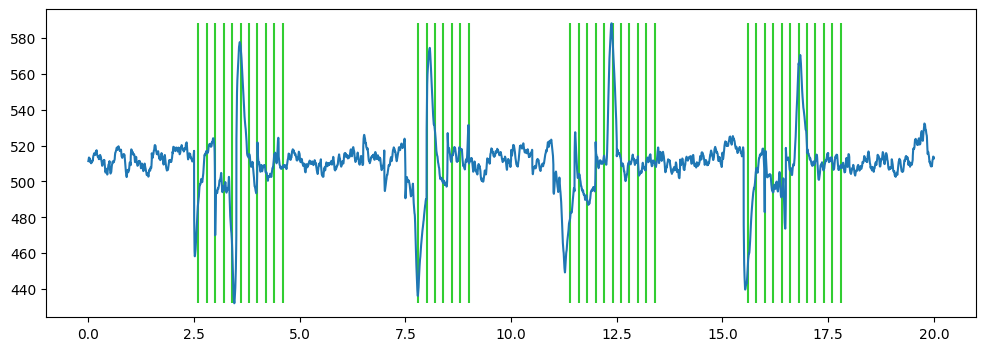

In [369]:
def classifier(amp):
    return np.var(amp) > 150

time, amp, laps = load_data(Path("./data/week9/2204looklefts1.csv"))

threshold = np.std(amp)

events = [*predict_event(time, amp,
                         classifier,
                         window_sec=0.1,
                         window_inc=0.1,
                         event_skip=0)]
plt.figure(figsize=(12, 4))
for event_start, event_end in events:
    plt.vlines(event_end, min(amp), max(amp), color="limegreen")
plot_data(time, amp, laps)
plt.savefig("2204doubleleft.png")
plt.show()

## Slice

In [583]:
clip_df = []
for path in tqdm(data_paths):
    week = re.search(r"/week(\d+)/", str(path)).group()
    for s in ("left", "right", "blink", "no", "test"):
        if s in str(path):
            label = s
            break
    else:
        raise ValueError()

    double = "double" in str(path)

    window_sec = 1.0
    window_n = int(10_000 * window_sec)
    minimum_sec = 0.2
    minimum_n = int(10_000 * minimum_sec)
    
    time, amp, laps = load_data(path)
    
    amp_med = np.median(amp)
    error = amp - amp_med
    std = np.convolve(error ** 2, np.ones(window_n), "full")[:-(window_n - 1)] / window_n
    event = (std > 150).astype(int)
    for i, j in np.where(np.diff(np.r_[0, event, 0]))[0].reshape(-1, 2):
        if j - i < minimum_n:
            continue
        clip_time = time[max(0, i - window_n):j]
        clip_amp = amp[max(0, i - window_n):j]
        clip_df.append({
            "week": week,
            "path": str(path),
            "label": label,
            "double": double,
            "time": clip_time,
            "amp": clip_amp,
        })

clip_df = pd.DataFrame(clip_df)

  0%|          | 0/25 [00:00<?, ?it/s]

In [777]:
tqdm.pandas()

def clip_features(amp):
    high_peaks, high_prop = find_peaks(amp, prominence=50)
    low_peaks, low_prop = find_peaks(-amp, prominence=50)
    peaks = np.sort(np.r_[high_peaks, low_peaks])
    return {
        "interval": np.mean(np.diff(peaks)),
        "high_mean": np.mean(high_prop["prominences"]),
        "low_mean": np.mean(low_prop["prominences"])
    }

clip9_df = clip_df[
    (~clip_df["label"].isin(["test", "no"]))
    & (~clip_df["double"])].reset_index()
clip_feat = pd.DataFrame([*clip9_df["amp"].progress_apply(clip_features)])
clip_feat_df = clip9_df.drop(columns=["time", "amp"]).join(clip_feat)
clip_feat_df

  0%|          | 0/54 [00:00<?, ?it/s]

,index,week,path,label,double,interval,high_mean,low_mean
0,0,/week6/,data/week6/40secondblinkwithlaps.csv,blink,False,1021.000000,124.314129,61.928353
1,1,/week6/,data/week6/40secondblinkwithlaps.csv,blink,False,4875.000000,61.128278,95.308762
2,2,/week6/,data/week6/40secondblinkwithlaps.csv,blink,False,1206.000000,92.682947,51.073680
3,3,/week6/,data/week6/40secondblinkwithlaps.csv,blink,False,NaN,121.149479,NaN
4,4,/week6/,data/week6/40secondblinkwithlaps.csv,blink,False,4849.000000,65.576715,77.734397
5,5,/week6/,data/week6/40secondblinkwithlaps.csv,blink,False,2432.000000,67.061173,78.830643
6,6,/week6/,data/week6/40secondblinkwithlaps.csv,blink,False,NaN,82.829337,NaN
7,7,/week6/,data/week6/40secondblinkwithlaps.csv,blink,False,NaN,55.767587,NaN
8,8,/week6/,data/week6/40secondblinkwithlaps.csv,blink,False,974.000000,112.374181,50.315348
9,9,/week6/,data/week6/40secondblinkwithlaps.csv,blink,False,1031.000000,101.312841,62.669284


In [778]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

X = clip_feat_df.iloc[:, 6:].to_numpy()
y = (clip_feat_df["label"] == "blink").to_numpy()

kf = KFold(n_splits=5)
scores = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

    scalar = StandardScaler()
    X_scaled = scalar.fit_transform(X)
    model = DecisionTreeClassifier(max_depth=2)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
np.mean(scores)

0.5236363636363637

0.7592592592592593

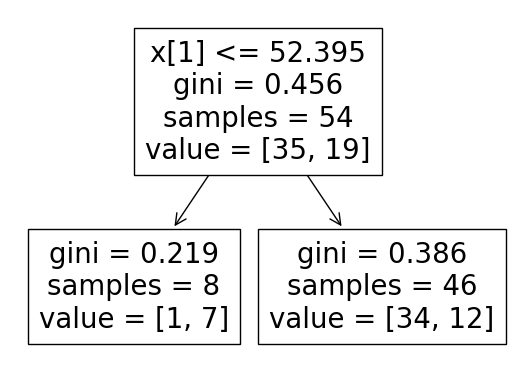

In [779]:
from sklearn.tree import plot_tree

model = DecisionTreeClassifier(max_depth=1)
model.fit(X, y)
plot_tree(model)
model.score(X, y)

## Clustering with Auto-correlation

In [35]:
df_acf_lr = pd.DataFrame()
for _, clips in labeled_clips.items():
    df_acf_lr = pd.concat([df_acf_lr,
                           pd.DataFrame([acf_features(clip) for clip in clips])],
                          ignore_index=True)
df_acf_lr

,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10
0,0.999990,9.998414,0.114816,0.131290,-0.499979,0.249979
1,0.999779,9.974689,0.094035,0.086832,-0.499899,0.249899
2,0.999436,9.933080,0.018325,0.003235,-0.499964,0.249964
3,0.999977,9.996892,0.122855,0.150708,-0.499993,0.249993
4,0.999876,9.983825,0.031234,0.009275,-0.499914,0.249914
5,0.999910,9.989299,0.114818,0.130251,-0.499957,0.249957
6,0.999949,9.993427,0.050587,0.025332,-0.499974,0.249974
7,0.999850,9.982535,0.031715,0.009788,-0.499953,0.249953
8,0.999981,9.997449,0.053383,0.028451,-0.499998,0.249998
9,0.999814,9.979000,0.065560,0.042840,-0.499995,0.249995
